# TOPIC Modelling
Ce notebook est très fortement inspiré de cet exemple: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [1]:
import pandas as pd
import numpy as np
import spacy

## Import des données
Les données suivantes sont des tweets dont l'utilisateur est "diagnostiqué anxieux ou pas.

In [2]:
df = pd.read_pickle("test_anx_2019.pkl", compression="zip")
df.head()

,subject,text,at_risk
0,subject1001,First Submission. Strikeforce: Rockhold vs J...,0
1,subject1001,"Gainesville, FL \t Need an atheist haven in G...",0
2,subject1001,Bill Maher discusses Atheism not being a reli...,0
3,subject1001,UG member relates horrors of unregulated MMA ...,0
4,subject1001,\t Judging by the look he gave her when he ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570509 entries, 0 to 570508
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   subject  570509 non-null  object
 1   text     570509 non-null  object
 2   at_risk  570509 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 13.1+ MB


In [4]:
print("Nombre de sujets étudiés: %d" % df.subject.nunique())
print("Nombre de sujets à risque: %d" % df[df.at_risk == 1].subject.nunique())
print("Pourcentage de tweets de sujets à risque: %.2f" % ((df.at_risk.value_counts()[1]*100)/len(df)))

Nombre de sujets étudiés: 815
Nombre de sujets à risque: 73
Pourcentage de tweets de sujets à risque: 3.09


In [5]:
df2 = pd.read_pickle("train_anx_2019.csv", compression="zip")
df2.head()

,subject,text,at_risk
0,subject1001,First Submission. Strikeforce: Rockhold vs J...,0
1,subject1001,"Gainesville, FL \t Need an atheist haven in G...",0
2,subject1001,Bill Maher discusses Atheism not being a reli...,0
3,subject1001,UG member relates horrors of unregulated MMA ...,0
4,subject1001,\t Judging by the look he gave her when he ...,0


In [ ]:
# work on sample

## Nettoyage avec Spacy
-  Lemmatisation
-  Stopwords

In [58]:
import os

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pyLDAvis

import spacy
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")




In [59]:
# Récupère les tweets des sujets à risque
s = df[df.at_risk == 1]
s = s.sample(1000)

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

docs = (nlp(tweet) for tweet in s.text)
corpus = []
for tweet in lemmatizer.pipe(docs, batch_size=50):
    corpus.append(" ".join([w.lemma_ for w in tweet if w.lemma_ not in spacy_stopwords]))

In [8]:
corpus

['   \t   yes , persistent pressure community , beginning . QB ask lonely , play npc expect eventually find like " " . I treat I shelter impede sort progress .   happy way thing .',
 '   \t  experience , symptom viability pregnancy . symptom come sooo trimester ridiculous . single time I panic . , I think symptom away pregnancy end miscarriage probably coincidence , symptom completely away time . normal end trimester stop symptom placenta hormone production .  ',
 '   \t   good way generally enjoy - relaxing game experience , like Proteus , game focus bring fruition idea , like Minecraft .    sort thing sidestep fact reflex reasoning ability realistically , focus distinct personality , memory idea .  ',
 '   \t  moment . stuck night hopefully leave morning . I 2 puppy I try find pet friendly hotel room available . blockade right hard area .  ',
 '   \t   ... good friend / pen pal .   honestly , 17 ( sound like ass ) lot grow learning fun experience .   end . . wo able ? plane ? train ?

In [78]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Les mots qui apparaissent moins de 3 fois sont supprimés, 
vectorizer = CountVectorizer(
                            stop_words = 'english',
                            min_df=10,
                            max_features=10000
                            )

doc_term_matrix = vectorizer.fit_transform(corpus)

## Check the Sparcity

In [79]:
# Materialize the sparse data
data_dense = doc_term_matrix.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.2909365558912387 %




### LDA
le nombre de component au départ est prit au hasard car nous ne disposons pas de connaissances 
préalables sur les troubbles anxieux.

In [80]:
lda_model = LatentDirichletAllocation(n_components=3,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=666,
                                     evaluate_every = -1,
                                     n_jobs=-1,
                                     )
lda_output = lda_model.fit_transform(doc_term_matrix)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=3, n_jobs=-1,
                          random_state=666)


### Diagnostique du modèle

In [63]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_term_matrix))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_term_matrix))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -110880.56018637096
Perplexity:  932.759508297115
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 666, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Recherche des meilleurs paramètres

In [64]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [2, 4, 6, 8], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_term_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 4, 6, 8]})

In [65]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -25040.31406119271
Model Perplexity:  912.1484630294054


In [66]:
result_df = pd.DataFrame(model.cv_results_)

log_likelyhoods_5 = result_df[result_df["param_learning_decay"]==0.5]["mean_test_score"]
log_likelyhoods_7 = result_df[result_df["param_learning_decay"]==0.7]["mean_test_score"]
log_likelyhoods_9 =  result_df[result_df["param_learning_decay"]==0.9]["mean_test_score"]

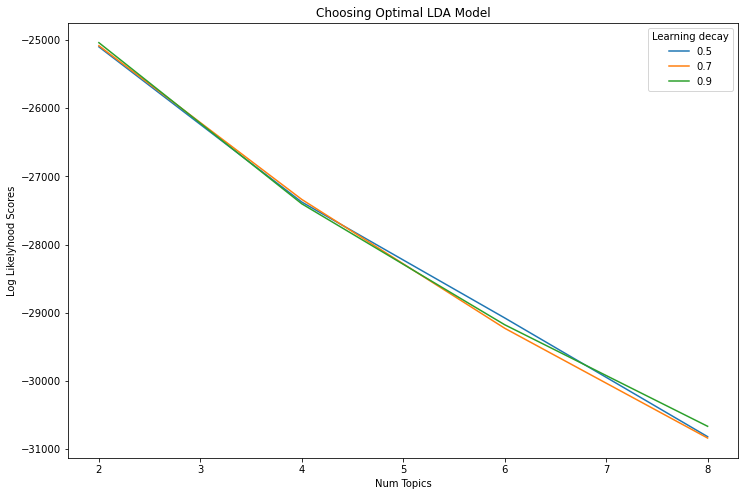

In [67]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [2, 4, 6, 8]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Classifier un document selon son topic
### Vérifier le topic dominant de chaque document en regardant lequel à la plus haute contribution pour chaqun des documents

In [68]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_term_matrix)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.130000,0.870000,1
Doc1,0.820000,0.180000,0
Doc2,0.870000,0.130000,0
Doc3,0.750000,0.250000,0
Doc4,0.190000,0.810000,1
Doc5,0.500000,0.500000,0
Doc6,0.140000,0.860000,1
Doc7,0.070000,0.930000,1
Doc8,0.960000,0.040000,0
Doc9,0.500000,0.500000,0


#### Distribution des topics

In [69]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,638
1,1,362


## Visualisations

In [70]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_term_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  73.730715
1      60.312561 -141.369141       2        1  26.269285, topic_info=        Term        Freq       Total Category  logprob  loglift
1254   thank   74.000000   74.000000  Default  30.0000  30.0000
744     look   80.000000   80.000000  Default  29.0000  29.0000
901   people  199.000000  199.000000  Default  28.0000  28.0000
624     http   33.000000   33.000000  Default  27.0000  27.0000
247      com   58.000000   58.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
579     hard   17.260641   52.246331   Topic2  -5.5085   0.2292
1262   think   21.353840  181.996551   Topic2  -5.2957  -0.8060
1181   start   16.909232   62.555966   Topic2  -5.5291   0.0286
725     like   19.885304  353.241523   Topic2  -5.3669  -1.5404
488     feel   15.486176  144.012198   Topic2  -5.6170  -0.8932

[154 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.879799     00
1         1  0.140851     10
1         2  0.892056     10
41        1  0.991179    act
49        1  0.070647    add
...     ...       ...    ...
1393      2  0.030589  wrong
1397      1  0.747496   year
1397      2  0.249165   year
1398      1  0.970275    yes
1398      2  0.033458    yes

[194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Retrouver les mots clés des topics

In [71]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,00,10,100,1000,11,12,13,14,15,16,...,wrong,wtf,www,yeah,year,yes,young,youtube,zero,zombie
Topic0,0.510195,2.872925,5.279054,2.493626,1.638147,2.597172,3.328333,2.470463,2.183482,2.267235,...,34.214609,0.529963,25.086883,9.754558,45.093492,31.259324,4.480957,15.639394,0.585153,5.383315
Topic1,8.489805,21.127075,1.720946,1.506374,5.361853,7.402828,0.671667,2.529537,9.816518,4.732765,...,0.785391,3.470037,3.913117,13.245442,15.906508,0.740676,0.519043,2.360606,6.414847,0.616685


In [72]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,like,people,know,think,feel,time,thing,want,good,use,way,try,lot,come,tell
Topic 1,thank,look,eat,com,love,good,http,day,little,lol,work,try,time,think,remove


# Prédire le topic pour un nouveau Tweet

In [ ]:
# # Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

Text(0.5, 1.0, 'Segregation of Topic Clusters')

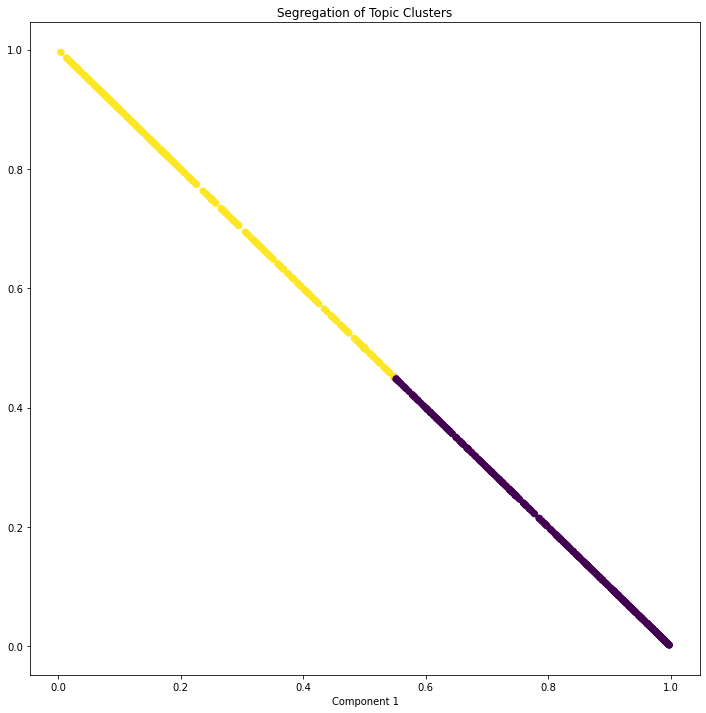

In [73]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=2, random_state=100).fit_predict(lda_output)

# # Build the Singular Value Decomposition(SVD) model
# svd_model = TruncatedSVD(n_components=2)  # 2 components
# lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output[:, 0]
y = lda_output[:, 1]

# Weights for the 15 columns of lda_output, for each component
# print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
# print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [84]:
lda_model = LatentDirichletAllocation(n_components=50, random_state=888)
lda_model.fit(doc_term_matrix)
data = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(data)

0.0